In [10]:

import csv
import numpy as np

import scipy.stats as sp

from scipy import sparse

import math

from scipy.sparse.linalg import spsolve

from scipy.linalg import cholesky

from scipy.stats import norm

from scipy.signal import find_peaks, peak_widths

import matplotlib.pyplot as plt

from numpy.linalg import norm

from scipy.sparse import linalg


#np.seterr(divide='ignore', invalid='ignore')
class GaussianMixModel():
    def __init__(self, data):

        np.seterr(divide='ignore', invalid='ignore')

        self.data = data
        data1 = np.array(data).astype('int')
        data1 = data1.reshape(72, 8)

        self.x = data1[:, 0]
        self.y = data1[:, 1:]

        #self.y = np.ravel(self.y)

        #self.y = np.reshape(self.y, (72,7))
        #self.y = self.y.reshape(-1,7)
        self.y1 = self.y.T
        self.x1 = self.x.reshape(1, -1)

        #self.m, self.n = data1.shape

        self.res_par = 0.5  # res_par - used in the main body of ms_gmm - multiplied by estimated average width of the peak in the spectrum defines resolutioon of the  decomposition

        self.par_p_sens = 0  # par_p_sens parameter for peak detection sensitivity used in find_split_peaks split peaks must be of height >= Par_P_Sens * maximal peak height

        self.par_q_thr = 1.3  # par_q_thr parameter for peak quality threshold used in find_split_peaks split peaks must have quality >= Par_Q_Thr

        self.par_ini_j = 5  # par_ini_j parameter for initial jump used in find_split_peaks

        self.par_p_l_r = 4  # par_p_l_r parameter for range for peak lookup used in find_split_peaks

        self.par_p_j = 4  # par_p_j parameter for jump used in find_split_peaks

        self.qfpar = 0.5  # qfpar - parameter used in the dynamic programming quality funtion

        self.prec_par_1 = 0.002  # prec_par_1 - precision parameter - weight used to pick best gmm decomposition penalty coefficient for number of components in the quality funtio

        #res_par_2 - used in the EM iterations to define lower bounds for standard deviations
        self.res_par_2 = 0.5

        # penet_par_1  - penetration parameter 1 used to continue searching for best number of components in gmm decomposition (bigger for splitting segments)
        self.penet_par_1 = 15

        # prec_par_2 - precision parameter 2 - weight used to pick best gmm decomposition
        self.prec_par_2 = self.penet_par_1

        # penet_par_1  - penetration parameter 2 used to continue searching for best number of components in gmm decomposition (smaller for segments)
        self.prec_par_2 = 15

        # buf_size_split_par - size of the buffer for computing GMM paramters of splitters
        self.buf_size_split_par = 10

        # buf_size_seg_par - size of the buffer for computing GMM paramters of segments
        self.buf_size_seg_par = 30

        # eps_par - parameter for EM iterations - tolerance for mixture parameters change
        self.eps_par = 0.0001

        self.draw = 1  # draw - show plots of decompositions during computations used in many finctions

In [4]:
       def baseline_removals(self, data, lam=1e4, ratio=0.05, itermax=100):
        """
        Baseline correction using asymmetrically
        reweighted penalized least squares smoothing
        Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
        Analyst, 2015, 140, 250 (2015)
        y:
                input data (i.e. chromatogram of spectrum)
            lam:
                parameter that can be adjusted by user. The larger lambda is,
                the smoother the resulting background, z
            ratio:
                wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
            itermax:
                number of iterations to perform
        Output:
            the fitted background vector

        """
        data = self.data
        y = self.y1
        x = self.x1
        #y_base = 0
        for i in range(len(y[0])):
            N = len(y[0])
            D = sparse.eye(N, format='csc')
            # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
            D = D[1:] - D[:-1]
            D = D[1:] - D[:-1]
            H = lam * D.T * D
            w = np.ones(N)
            #w = np.squeeze(np.asarray(w))
            # offset = np.zeros(7)

            for j in range(itermax):
                W = sparse.diags(w, 0, shape=(N, N)) # (72,) (72, 2)
                WH = sparse.csc_matrix(W + H)
                C = sparse.csc_matrix(cholesky(WH.todense()))
                tmp = y[i, :] * w
                gh = spsolve(C.T, tmp.T)
                y_base = spsolve(C, gh)# spsolve(C, spsolve(C.T, w * y))
                d = y - y_base
                dn = d[d < 0]
                m = np.mean(dn)
                s = np.std(dn)
                wt = 1 / (1 + np.exp(2 * (d - (2 * s - m)) / s))  #(72,7)
                if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
                    break
                w = wt
            return y_base


In [5]:
    def bindata(self, data, bins):
        # function [ym,yb] = bindata(y,x,xrg)
        # Computes ym(ii) = mean(y(x>=xrg(ii) & x < xrg(ii+1)) for every ii
        # using a fast algorithm which uses no looping
        # If a bin is empty it returns nan for that bin
        # Also returns yb, the approximation of y using binning (useful for r^2 calculations). Example:
        # x = randn(100,1)
        # %y = x.^2 + randn(100,1)
        # xrg = linspace(-3,3,10)'
        # [ym,yb] = bindata(y,x,xrg)
        # X = [xrg(1:end-1),xrg(2:end)]'
        # Y = [ym,ym]'
        # plt.plot(x,y,'.',X(:),Y(:),'r-')
        data = self.data
        y = baseline_removals.y_base
        x = self.x1
        #print(y)
        #print(y.shape)
        for i in range(y.shape[0]):
            try:
                bins = np.linspace(y.min(), y.max(), 100, endpoint=False)
        # digitized = np.digitize(y, bins) #histc
        # returns ind, an array the same size as x indicating the bin number that each entry in x sorts into. Use this syntax with any of the previous input argument combinations.
        #bin_means = [y[digitized == i].mean() for i in range(1, len(bins))]
                bin_means = (np.histogram(y, bins, weights=y)[0] / np.histogram(y, bins)[0])

            except ZeroDivisionError:
                return 0
            return bin_means


In [ ]:
def dyn_pr_split_w(self, data, ygreki, k_gr, aux_mx, par, par_sig_min):
    data = self.data
    par_sig_min = gmm_decomp_split_segment.par_sig_min
    # initialize
    Q = np.zeros(1, K_gr)
    N = len(data)
    p_opt_idx = np.zeros(1, N)
    p_aux = np.zeros(1, N)
    opt_pals = np.zeros(k_gr, N)
    for kk in range(1, N):
        p_opt_idx[kk] = my_qu_ix_w(data[kk:N], ygreki[kk:N], par, par_sig_min)

    # aux_mx - already computed

    # iterate
    for kster in range(1, k_gr):
        for kk in range(1, N - kster):
            for jj in range(kk + 1, N - kster + 1):
                p_aux[jj] = aux_mx[kk, jj] + p_opt_idx[jj]

        mm, ix = min(p_aux[kk + 1:N - kster + 1])
        p_opt_idx[kk] = mm
        opt_pals[kster, kk] = kk + ix[1]

    Q[kster] = p_opt_idx[1]

    # restore optimal decisions
    opt_part = zeros(1, k_gr)
    opt_part[1] = opt_pals(k_gr, 1)
    for kster in range(k_gr-1, 1, -1):
        opt_part[k_gr - kster + 1] = opt_pals(kster, opt_part[k_gr - kster])

    return (Q, opt_part)


In [ ]:
def dyn_pr_split_w_aux(self, data, ygreki, par, par_sig_min):
    data = self.data
    par_sig_min = gmm_decomp_split_segment.par_sig_min
    N = len(data)
    # aux_mx
    aux_mx = NP.zeros(N, N)
    for kk in range(1, N-1):
        for jj in range(kk+1, N):
            aux_mx[kk, jj] = my_qu_ix_w(
                data[kk:jj-1], ygreki[kk:jj-1], par, par_sig_min)

    return aux_mx


In [ ]:
# emergency correction function launched in the case of (rare) overlap between splitters
def emcor(self, ksp, mu_mx_1, ww_mx_1, sig_mx_1, x, y_bas, splitt_v, peaks, par_mcv):

    y_base = baseline_removals.y_base
    splitt_v = find_split_peaks.Splitt_v
    peaks = gmm.peaks
    par_mcv = gmm.par_mcv
    KSP = len(splitt_v)

    ww_a_l_new = 0 * ww_mx_1[1, :]
    mu_a_l_new = 0 * ww_mx_1[1, :]
    sig_a_l_new = 0 * ww_mx_1[1, :]

    ww_a_p_new = 0 * ww_mx_1[1, :]
    mu_a_p_new = 0 * ww_mx_1[1, :]
    sig_a_p_new = 0 * ww_mx_1[1, :]

    if ksp > 0:
        mu_l = mu_mx_1[ksp, :]
        ww_l = ww_mx_1[ksp, :]
        sig_l = sig_mx_1[ksp, :]
        ixp = max(np.argwhere(ww_l > 0))

        if len(ixp) == 0:
            KSll = 0
            xll = x[1]
            mu_l = []
            ww_l = []
            sig_l = []
        else:
            mu_l = mu_l[1: ixp]
            ww_l = ww_l[1: ixp]
            sig_l = sig_l[1: ixp]
            KSll = len(ww_l)
            xll, xlp = find_ranges(mu_l, sig_l)
    else:
        KSll = 0
        xll = x[1]
        mu_l = []
        ww_l = []
        sig_l = []

    if ksp < KSP:
        mu_p = mu_mx_1[ksp + 1, :]
        ww_p = ww_mx_1[ksp + 1, :]
        sig_p = sig_mx_1[ksp + 1, :]
        ixp = max(np.argwhere(ww_p > 0))
        mu_p = mu_p[1: ixp]
        ww_p = ww_p[1: ixp]
        sig_p = sig_p[1: ixp]
        KSpp = len(ww_p)
        xlp, xpp = find_ranges(mu_p, sig_p)
    else:
        KSpp = 0
        xpp = x[-1]
        mu_p = []
        ww_p = []
        sig_p = []

    idm = np.argwhere(x >= xll & x <= xpp)
    x_o = x[idm]
    y_o = y_bas[idm]
    pyl = 0 * x_o
    pyp = 0 * x_o

    if ksp > 0:
        for kks in range(1, KSll):
            norm_pdf = 1/(sig_l[kks] * np.sqrt(2 * math.pi)) * \
                np.exp(-1 * (x_o - mu_l[kks]) ** 2 / 2 * sig_l[kks] ** 2)
            pyl = pyl + ww_l[kks] * norm_pdf
        idl = np.argwhere(x_o >= xll & x_o <= peaks(splitt_v[ksp], 1))

        pylpds = pyl[idl]
        y_o[idl] = pylpds

    if ksp < KSP:
        for kks in range(1, KSpp):
            norm_pdf = 1/(sig_p[kks] * np.sqrt(2 * math.pi)) * np.exp(-1 * (x_o - mu_p[kks]) ** 2 / 2 * sig_p[kks] ** 2)
            pyp = pyp + ww_p[kks] * norm_pdf

        idp = np.argwhere(x_o >= peaks(splitt_v[(ksp + 1)], 1) & x_o <= xpp)
        pyppds = pyp[idp]
        y_o[idp] = pyppds

    KS = KSll + KSpp

    pp_ini = np.array(ww_l, ww_p) / np.sum(np.array(ww_l, ww_p))
    mu_ini = np.array(mu_l, mu_p)
    sig_ini = np.array(sig_l, sig_p)

    PAR_sig_min = self.res_par_2 * par_mcv * np.mean(x_o)
    pp_est, mu_est, sig_est = my_EM_iter(
        x_o, y_o, pp_ini, mu_ini, sig_ini, 0, self.par_sig_min, self.em_tol)
    KS = len(pp_est)
    KSpp = KS - KSll

    _, scale = qua_scal(x_o, y_o, pp_est, mu_est, sig_est)
    ww_est = pp_est * scale

    if ksp > 0:
        ww_a_l_new[1: KSll] = ww_est[1: KSll]
        mu_a_l_new[1: KSll] = mu_est[1: KSll]
        sig_a_l_new[1: KSll] = sig_est[1: KSll]

    if ksp < KSP:
        ww_a_p_new[1: KSpp] = ww_est[KSll + 1: KS]
        mu_a_p_new[1: KSpp] = mu_est[KSll + 1: KS]
        sig_a_p_new[1: KSpp] = sig_est[KSll + 1: KS]

    # ok = plot_res_new_scale(x_o, y_o, ww_est, mu_est, sig_est)

    return (ww_a_l_new, mu_a_l_new, sig_a_l_new, ww_a_p_new, mu_a_p_new, sig_a_p_new)


In [ ]:
def f_par_mcv(self, kini, fst, peaks, par_mcv):
    # kini = peaks[0]# kini - initial position of the peak counter
    # fst - number of forward steps intended to make
    peaks = self.peaks
    par_mcv = self.par_mcv
    fst_new = 0
    if kini + fst > np.size(peaks, 1):
        fst_new = 0
    else:
        fst_new = fst
        while True:
            if peaks[kini+fst_new, 1] - peaks[kini, 1] > fst * par_mcv * peaks[kini, 1]:
                break
            else:
                fst_new += 1
                if kini + fst_new > np.size(peaks, 1):
                    fst_new = 0
                    break
        return fst_new


In [ ]:
def fill_red(self, ww_v, mu_v, sig_v):
    KS = len(ww_v)
    xl, xp = find_ranges(mu_v, sig_v)
    dlx = (xp - xl) / 100
    xr = np.arange(xl, xp, dlx)
    py = 0 * xr
    for kks in range(1, KS):
        norm_pdf = 1/(sig_v[kks] * np.sqrt(2 * math.pi)) * \
            np.exp(-1 * (xr - mu_v[kks]) ** 2 / 2 * sig_v[kks] ** 2)
        py = py + (ww_v[kks] * norm_pdf)

    plt.figure(xr, py, 'r')


In [ ]:
def find_ranges(self, mu_v, sig_v):
    K = len(mu_v)
    mzlv = np.zeros(K, 1)
    mzpv = np.zeros(K, 1)

    for kk in range(1, K):
        mzlv[kk] = mu_v[kk] - 3 * sig_v[kk]
        mzpv[kk] = mu_v[kk] + 3 * sig_v[kk]

    mzlow = min(mzlv)
    mzhigh = max(mzpv)
    return (mzlow, mzhigh)


In [ ]:
# find segment between two neighboring splitters
def find_segment(self, ksp, peaks, splitt_v, x, y_bas, mu_l, ww_l, sig_l, mu_p, ww_p, sig_p):
    splitt_v = find_split_peaks.Splitt_v
    KSP = len(splitt_v)

    if ksp > 0:
        xl = peaks(splitt_v[ksp], 1)
    else:
        xl = x[1]
    if ksp < KSP:
        xp = peaks(splitt_v[ksp + 1], 1)
    else:
        xp = x(len(x))

    idm = np.argwhere(x >= xl & x <= xp)
    x_o = x[idm]
    y_o = y_bas[idm]

    if self.draw == 1:
        xll = max((xl - round((xp - xl) / 5)), x[1])
        xpp = min((xp + round((xp - xl) / 5)), x(len(x)))
        ixmzp = np.argwhere((x > xll) & (x < xpp))
        mz_o_p = x[ixmzp]
        y_o_p = y_bas[ixmzp]
        # figure(2)
        plt.subplot(3, 1, 1)
        plt.plot(x_o_p, y_o_p, 'k')
        plt.title('Splitters')

    pyl = 0 * x_o
    if ksp > 0:
        KS = len(ww_l)
        for kks in range(1, KS):
            norm_pdf = 1/(sig_l[kks] * np.sqrt(2 * math.pi)) * \
                np.exp(-1 * (x_o - mu_l[kks]) ** 2 / 2 * sig_l[kks] ** 2)
            pyl = pyl + ww_l[(kks)] * norm_pdf

        if self.draw == 1:
            ok = fill_red(ww_l, mu_l, sig_l)

    pyp = 0 * x_o
    if ksp < KSP:
        KS = len(ww_p)
        for kks in range(1, KS):
            norm_pdf = 1/(sig_p[kks] * np.sqrt(2 * math.pi)) * \
                np.exp(-1 * (x_o - mu_p[kks]) ** 2 / 2 * sig_p[kks] ** 2)
            pyp = pyp + ww_p[kks] * norm_pdf
        if self.draw == 1:
            ok = fill_red(ww_p, mu_p, sig_p)

    y_out = y_o - pyl - pyp

    if ksp > 0:
        iyl = np.argwhere(pyl > 0.05 * max(pyl))
        if len(iyl) > 1:
            x_ol = x_o[iyl]
            y_ol = y_out[iyl]
            mp = min(y_ol)
            imp = y_ol.index(min(y_ol))
            x_l = x_ol(imp[1])
        else:
            x_l = x_o[1]

    else:
        x_l = xl

    if ksp < KSP:
        iyp = np.argwhere(pyp > 0.05 * max(pyp))
        if len(iyp) > 1:
            x_op = x_o[iyp]
            y_op = y_out[iyp]
            mp = min(y_op)
            imp = y_op.index(min(y_op))
            x_p = x_op[imp[1]]
        else:
            x_p = x_o(len(x_o))
    else:
        x_p = xp

    ix = np.argwhere((x_o <= x_p) & (x_o >= x_l))
    y_out = y_out[ix]
    x_out = x_o[ix]

    iy = np.argwhere(y_out > 0)
    y_out = y_out[iy]
    x_out = x_out[iy]

    if self.draw == 1:
        plt.subplot(3, 1, 2)
        plt.plot(x_o, 0 * y_o, 'r')
        plt.plot(x_out, y_out, 'k')
        #plt.title('Segment:' str(ksp))


In [ ]:
def find_split_peaks(self, peaks, x, y, par_mcv):
    peaks = gmm.peaks
    x = self.x
    y = baseline_removals.y_base
    par_mcv = gmm.par_mcv
    seg_vec = np.zeros((np.size(peaks, 1), 1))

    for k in range(1, np.size(peaks, 1)):
        zakm = np.argwhere(x <= peaks(k + 1, 1) & x >= peaks(k, 1))
        warty = y(zakm)
        miny = min(warty)
        idxm_min_y = warty.index(miny)
        prawzak = zakm(idxm_min_y(1))
        seg_vec[k] = prawzak

    seg_vec.shape = max(x.shape)
    seg_vec_c = np.concatenate((1, seg_vec), axis=0)
    M_B_H = np.zeros(np.size(peaks, 1), 1)
    for kk in range(1, np.size(peaks, 1)):
        if y(seg_vec_c[kk]) >= y(seg_vec_c[kk]):
            M_B_H[kk] = y(seg_vec_c[kk]) + 1
        else:
            M_B_H[kk] = y(seg_vec_c[kk+1]) + 1

    max_peaks = np.max(peaks)
    ppe = peaks / M_B_H
    Kini = GaussianMixModel.f_par_mcv(1, self.par_p_l_p, peaks, par_mcv)
    Splitt_v = np.zeros(np.floor(((np.max(x) - x[0]) / x[0] * par_mcv)), 1)
    kspl = 0

    while True:
        if GaussianMixModel.f_par_mcv(Kini, self.par_p_l_p, peaks, par_mcv) == 0:
            break

        Top = Kini + \
            GaussianMixModel.f_par_mcv(Kini, self.par_p_l_p, peaks, par_mcv)
        Zak = np.array(Kini, Top)
        # verify quality condition for the best peak in the range Zak=Kini:Top
        pzak2 = peaks(Zak, 1)

        ppezak = ppe(Zak)
        ixq = np.argwhere(pzak2 > (self.par_p_sens * max_peaks)
                          & ppezak > self.par_q_thr)

        if np.size(ixq) >= 1:
            [mpk, impk] = np.max(ppe(Zak[ixq]))
            kkt = ixq(impk[0])
            kspl += 1
            Splitt_v[kspl] = Zak[kkt]
            Kini = Top+f_par_mcv(Top, self.par_p_j, peaks, par_mcv)

        else:
            Kini = Top + f_par_mcv(Top, 1, peaks, par_mcv)

    Splitt_v = np.rane(1, kspl)
    return np.array(Splitt_v, seg_vec_c)


In [ ]:
# find splitter segment around the split peak no k

def find_split_segment(self, k_pick, x, y_bas, seg_vec_c, peaks, par_mcv):
    x = self.x
    y_base = baseline_removals.y_base
    splitt_v = find_split_peaks.Splitt_v
    seg_vec_c = find_split_peaks.seg_vec_c
    peaks = gmm.peaks
    par_mcv = gmm.par_mcv

    zakl = seg_vec_c.max(1, (k_pick-4))
    zakp = seg_vec_c.min(np.size(peaks, 1), (k_pick+5))

    mzp = x[zakp]
    mzl = x[zakl]
    mzPP = peaks[k_pick, 1]

    if (mzp-mzPP) < 5 * mzPP * par_mcv:
        zakm = np.argwhere(x >= mzp & x <= mzp + 5 * mzPP * par_mcv)
        warty = y_bas[zakm]
        miny = warty.min()
        idxm = miny.index(min(miny))
        prawzak = zakm[idxm[1]]
    else:
        prawzak = zakp

    if (mzPP-mzl) < 5 * mzPP * par_mcv:
        zakm = np.argwhere(x <= mzl & x >= mzl - 5 * mzPP * par_mcv)
        warty = y_bas[zakm]
        miny = warty.min()
        idxm = miny.index(min(miny))
        lewzak = zakm[idxm[1]]
    else:
        lewzak = zakl

    x_o = x[lewzak:prawzak]
    y_bas_o = y_bas[lewzak:prawzak]

    yp = y_bas[prawzak]
    yl = y_bas[lewzak]

    dxl = x[lewzak+1] - x[lewzak]
    dxp = x[prawzak] - x[prawzak-1]

    j = np.arange(x[lewzak], (x[lewzak]-dxl), dxl)
    o = np.arange(dxp, x[prawzak], dxp)

    xaugl = x[lewzak] - 6 * par_mcv * j
    xaugp = x[prawzak] + o + 6 * par_mcv * x[prawzak]

    mu = 0
    sigma_1 = 2 * par_mcv * x[prawzak]
    sigma_2 = 2 * par_mcv * x[lewzak]
    norm_pdf_1 = 1/(sigma_1 * np.sqrt(2 * math.pi)) * \
        np.exp(-1 * ((xaugp - mzp) - mu) ** 2 / 2 * sigma_1 ** 2)
    norm_pdf_2 = 1/(sigma_2 * np.sqrt(2 * math.pi)) * \
        np.exp(-1 * ((xaugl - mzl) - mu) ** 2 / 2 * sigma_2 ** 2)

    yop = np.sqrt(2 * math.pi) * (2 * par_mcv * x(prawzak)) * yp * norm_pdf_1
    yol = np.sqrt(2 * math.pi) * (2 * par_mcv * x(lewzak)) * yl * norm_pdf_2

    # x_ss = [xaugl'; mz_o; xaugp']
    # y_ss = [yol'; y_bas_o; yop']
    return (xaugl, yol)


In [ ]:
def gmm(self, x, y_base):
    x = self.x
    y_base = baseline_removals.y_base
    seg_vec_c = find_split_peaks.seg_vec_c

    splitt_v = find_split_peaks.Splitt_v
    # find peaks
    # peaks at which point, the value of the peak
    peaks, _ = find_peaks(x, height=0)
    results_half = peak_widths(x, peaks, rel_height=0.5)
    res_width = results_half[0]

    # estimate resolution
    par_mcv = self.res_par * \
        np.mean((res_width[:, 2] - res_width[:, 1])/peaks[:, 1])

    # find good quality splitting peaks
    splitt_v, seg_vec_c = find_split_peaks(peaks, x, y_base, par_mcv)
    KSP = np.max(splitt_v.shape)  # number of plitting peaks
    # buffers for splitter parameters
    mu_mx_1 = np.zeros(KSP, self.buf_size_split_par)
    ww_mx_1 = np.zeros(KSP, self.buf_size_split_par)
    sig_mx_1 = np.zeros(KSP, self.buf_size_split_par)

    for kk in range(1, KSP):
        #  disp(['split Progress: ' str[kk] ' of ' str[KSP])
        # Gaussian mixture decomposition of the splitting segment
        ww_pick, mu_pick, sig_pick = gmm_decomp_split_segment(
            x, y_bas, splitt_v, seg_vec_c, peaks, self.par_mcv, kk)
        mu_mx_1[kk, :] = mu_pick
        ww_mx_1[kk, :] = ww_pick
        sig_mx_1[kk, :] = sig_pick

     # PHASE 2 - GMM DECOMPOSITIONS OF SEGMENTS

     # buffers for segments decompositions paramteres
    KSP1 = KSP + 1
    mu_mx_2 = np.zeros(KSP1, self.buf_size_seg_Par)
    ww_mx_2 = np.zeros(KSP1, self.buf_size_seg_Par)
    sig_mx_2 = np.zeros(KSP1, self.buf_size_seg_Par)
    for ksp in range(1, KSP1):
     #    disp(['Seg Progress: ' num2str(ksp) ' of ' num2str(KSP1)])
        ww_out, mu_out, sig_out = gmm_decomp_segment(
            x, y_bas, ww_mx_1, mu_mx_1, sig_mx_1, peaks, splitt_v, par_mcv, ksp - 1)
        mu_mx_2[ksp, :] = mu_out
        ww_mx_2[ksp, :] = ww_out
        sig_mx_2[ksp, :] = sig_out

     # AGGREGATION
     # aggregate components computed in PHASE 1 and in PHASE 2

    NUMPICK = np.size(peaks, 1)
    mu_vec = np.zeros(7 * NUMPICK, 1)
    ww_vec = np.zeros(7 * NUMPICK, 1)
    sig_vec = np.zeros(7 * NUMPICK, 1)

    kacum = 0

    for ksp in range(1, KSP + 1):
        mu_a = mu_mx_2[ksp, :]
        ww_a = ww_mx_2[ksp, :]
        sig_a = sig_mx_2[ksp, :]
        ixp = max(np.argwhere(ww_a > 0))
        if len(ixp) == 0:
            # emergency correction in the case of detected ovelap between splitters
            ww_a_l_new, mu_a_l_new, sig_a_l_new, ww_a_p_new, mu_a_p_new, sig_a_p_new = emcor(
                ksp - 1, mu_mx_1, ww_mx_1, sig_mx_1, x, y_bas, splitt_v, peaks, par_mcv)
            if ksp > 1:
                ww_mx_1[ksp - 1, :] = ww_a_l_new
                mu_mx_1[ksp - 1, :] = mu_a_l_new
                sig_mx_1[ksp - 1, :] = sig_a_l_new

            if ksp < KSP + 1:
                ww_mx_1[ksp, :] = ww_a_p_new
                mu_mx_1[ksp, :] = mu_a_p_new
                sig_mx_1[ksp, :] = sig_a_p_new

        else:
            mu_a = mu_a[1: ixp]
            ww_a = ww_a[1: ixp]
            sig_a = sig_a[1: ixp]
            for kk in range(1, len(ww_a)):
                kacum = + 1
                mu_vec[kacum] = mu_a[kk]
                ww_vec[kacum] = ww_a[kk]
                sig_vec[kacum] = sig_a[kk]

    for ksp in range(1, KSP):
        mu_a = mu_mx_1[ksp, :]
        ww_a = ww_mx_1[ksp, :]
        sig_a = sig_mx_1[ksp, :]
        ixp = max(np.argwhere(ww_a > 0))
        mu_a = mu_a[1: ixp]
        ww_a = ww_a[1: ixp]
        sig_a = sig_a[1: ixp]

        for kk in range(1, len(ww_a)):
            kacum = + 1
            mu_vec[kacum] = mu_a[kk]
            ww_vec[kacum] = ww_a[kk]
            sig_vec[kacum] = sig_a[kk]

    mu_vec = mu_vec[1: kacum]
    ww_vec = ww_vec[1: kacum]
    sig_vec = sig_vec[1: kacum]

    mu_sort, muixs = np.sort(mu_vec)
    mu_gmm = mu_sort
    ww_gmm = ww_vec[muixs]
    sig_gmm = sig_vec[muixs]

    return (ww_gmm, mu_gmm, sig_gmm)


In [ ]:
#       gmm decomposition of a segment based on
#       dynamic programming initialization
def gmm_decomp_segment(self, x, y_bas, ww_mx_1, mu_mx_1, sig_mx_1, peaks, splitt_v, par_mcv, fr_no):
    # buffers
    ww_dec = np.zeros(1, self.buf_size_seg_par)
    mu_dec = np.zeros(1, self.buf_size_seg_par)
    sig_dec = np.zeros(1, self.buf_size_seg_par)

    # assign fragment number to ksp
    KSP = len(splitt_v)
    ksp = fr_no

    # find separated fragments
    if ksp > 0:
        mu_l = mu_mx_1[ksp, :]
        ww_l = ww_mx_1[ksp, :]
        sig_l = sig_mx_1[ksp, :]
        ktr = max((np.where(ww_l > 0)))
        mu_l = mu_l[1: ktr]
        ww_l = ww_l[1: ktr]
        sig_l = sig_l[1: ktr]
    else:
        mu_l = []
        ww_l = []
        sig_l = []

    if ksp < KSP:
        mu_p = mu_mx_1[ksp+1, :]
        ww_p = ww_mx_1[ksp+1, :]
        sig_p = sig_mx_1[ksp+1, :]
        ktr = max((np.argwhere(ww_p > 0)))
        mu_p = mu_p[1:ktr]
        ww_p = ww_p[1:ktr]
        sig_p = sig_p[1:ktr]
    else:
        mu_p = []
        ww_p = []
        sig_p = []

    x_out, y_out = find_segment(
        ksp, peaks, splitt_v, x, y_bas, mu_l, ww_l, sig_l, mu_p, ww_p, sig_p)

    x_out = x_out[:]
    y_out = y_out[:]
    if len(x_out) > 300:
        dx = (x_out[len(x_out)] - x_out[1]) / 200
        x_out_bb = np.arange(x_out[1], x_out[len(x_out)], dx)
        x_out_b = x_out_bb[1:200] + 0.5 * dx
        y_out_b, yb = bindata(x_out, y_out, x_out_bb)
        ixnn = np.argwhere(~ math.isnan(y_out_b))
        y_out_b = y_out_b[ixnn]
        x_out_b = x_out_b[ixnn]
        y_out_b = y_out_b[:]
        x_out_b = x_out_b[:]
    else:
        y_out_b = y_out
        x_out_b = x_out

    # find appropriate gmm model for the segment

    quamin = np.inf
    N = len(x_out)
    Nb = len(x_out_b)
    PAR_sig_min = self.res_par_2 * self.par_mcv * np.mean(x_out)

    if len(x_out) < 3:
        continue

    else:
        KSmin = min(
            [1 (np.floor((x_out[N] - x_out[1]) / self.par_sig_min) - 1)])
        if KSmin <= 0:
            wwec = y_out / (np.sum(y_out))
            mu_est = np.sum(np.multiply(x_out, wwec))
            pp_est = 1
            sig_est = np.sqrt(np.sum(
                ((x_out - np.multiply(np.power(np.sum(np.multiply(x_out, wwec))), 2), wwec))))
            qua, scale = qua_scal(x_out, y_out, pp_est, mu_est, sig_est)
        else:
            KS = KSmin
            # penetration - how far are we searching for minimum
            par_penet = min(np.array(self.penet_par_2, np.array(
                np.floor((x_out[N] - x_out[1]) / self.par_sig_min), np.floor(len(x_out) / 4))))
            kpen = 0

            # name=['dane_nr' num2str(ksp)]
            # save(name, 'mz_out', 'y_out', 'mz_out_b', 'y_out_b', 'QFPAR', 'PAR_sig_min', 'PAR_penet');
            aux_mx = dyn_pr_split_w_aux(
                x_out_b, y_out_b, self.qfpar, self.par_sig_min)
            while KS < self.buf_size_seg_par:
                KS = KS + 1
                kpen = kpen + 1

                if KS > KSmin + 1 and KS >= len(x_out) / 2:
                    break

                Q, opt_part = dyn_pr_split_w(
                    x_out_b, y_out_b, KS-1, aux_mx, self.qfpar, self.par_sig_min)
                part_cl = np.array(1, opt_part, Nb+1)

                # set initial cond
                pp_ini = np.zeros[1, KS]
                mu_ini = np.zeros[1, KS]
                sig_ini = np.zeros[1, KS]
                for kkps in range(1, KS):
                    invec = x_out_b[part_cl[kkps]:part_cl[kkps+1]-1]
                    yinwec = y_out_b[part_cl[kkps]:part_cl[kkps+1]-1]
                    wwec = yinwec / (np.sum(yinwec))
                    pp_ini[kkps] = np.sum(yinwec) / np.sum(y_out)
                    mu_ini[kkps] = np.sum(np.multiply(invec, wwec))
                    # sig_ini[(kkps)]=sqrt(sum(((invec-sum(invec.*wwec')).^2).*wwec'))
                    sig_ini[kkps] = 0.5 * (max(invec) - min(invec))

                pp_est, mu_est, sig_est, TIC, l_lik, bic = my_EM_iter(
                    x_out, y_out, pp_ini, mu_ini, sig_ini, 0, self.par_sig_min, em_tol)

                # compute quality indices of gmm model of the fragment
                qua, scale = qua_scal(x_out, y_out, pp_est, mu_est, sig_est)
                quatest = qua + self.prec_par_2 * KS

                if (quatest < quamin):
                    quamin = quatest
                    pp_min = pp_est
                    mu_min = mu_est
                    sig_min = sig_est
                    scale_min = scale

                elif (quatest > quamin) and (kpen > self.par_penet):
                    pp_est = pp_min
                    mu_est = mu_min
                    sig_est = sig_min
                    scale = scale_min
                    break

        if self.draw == 1:
            # figure(2)
            plt.subplot(3, 1, 3)
            ok = plot_res_new_scale(
                x_out, y_out, pp_est * scale, mu_est, sig_est)
            plt.xlabel(str(fr_no),  str(len(pp_est)))

        ww_o = pp_est * scale
        mu_o = mu_est
        sig_o = sig_est

        for kkpick in range(1, len(ww_o)):
            mu_dec[kkpick] = mu_o(kkpick)
            ww_dec[kkpick] = ww_o(kkpick)
            sig_dec[kkpick] = sig_o(kkpick)

    return (ww_dec, mu_dec, sig_dec)


In [ ]:
def gmm_decomp_split_segment(self, x, y_base, splitt_v, seg_vec_c, p, par_mcv, sp_no):
    x = self.x
    y_base = baseline_removals.y_base
    splitt_v = find_split_peaks.Splitt_v
    seg_vec_c = find_split_peaks.seg_vec_c
    peaks = gmm.peaks
    par_mcv = gmm.par_mcv
    sp_no = None

    # input
    # mz,y_bas - spectrum
    # splitt_v, seg_vec_c - list of splitting peaks and segment bounds computed by find_split_peaks
    # peaks ,par_mcv - peaks,
    # sp_no - number of splitting segment

    #  find appropriate gmm model for the splitting segment no Sp_No
    # buffers
    ww_pick = np.zeros(1, self.buf_size_split_par)
    mu_pick = np.zeros(1, self.buf_size_split_par)
    sig_pick = np.zeros(1, self.buf_size_split_par)

    invec = np.zeros()
    yinwec = np.zeros()


    # un-binned data
    x_out, y_out = find_split_segment(
        splitt_v(sp_no), x, y_base, seg_vec_c, peaks, par_mcv)
    x_out = x_out[:]
    y_out = y_out[:]
    # bin if necessary
    if len(x_out) > 300:
        dx = (x_out(len(x_out)) - x_out[0]) / 200
        x_out_bb = np.arange((x_out(1), x_out(len(x_out)), dx))
        x_out_b = x_out_bb[1:200] + 0.5 * dx
        y_out_b, yb = bindata(x_out, y_out, x_out_bb)
        ixnn = np.argwhere(math.isnan(y_out_b))
        y_out_b = y_out_b[ixnn]
        x_out_b = x_out_b[ixnn]
        y_out_b = y_out_b[:]
        x_out_b = x_out_b[:]
    else:
        y_out_b = y_out
        x_out_b = x_out

    N = len(x_out)
    Nb = len(x_out_b)
    quamin = np.inf
    par_sig_min = self.res_par_2 * par_mcv * np.mean(x_out)
    KSmin = min([2, (np.floor((x_out[N] - x_out[1]) / par_sig_min) - 1)])
    if KSmin <= 0:
        wwec = y_out / (np.sum(y_out))
        mu_est = np.sum(np.multiply(x_out, wwec))
        pp_est = 1
        sig_est = np.sqrt(np.sum(np.multiply(((x_out - mu_est) ** 2), wwec)))
        qua, scale = qua_scal(x_out, y_out, pp_est, mu_est, sig_est)
    else:

        KS = KSmin
        par_penet = min([self.penet_par_1, np.floor(
            (x_out[N] - x_out[1]) / par_sig_min)])
        kpen = 0
        Q = 0

        aux_mx = dyn_pr_split_w_aux(x_out_b, y_out_b, self.qfpar, par_sig_min)
        while KS <= 2 * (KSmin + par_penet):
            KS = KS + 1
            kpen = kpen + 1

            Q, opt_part = dyn_pr_split_w(
                x_out_b, y_out_b, KS - 1, aux_mx, self.qfpar, par_sig_min)
            part_cl = np.array(1, opt_part, Nb + 1)

            # set initial cond
            pp_ini = np.zeros(1, KS)
            mu_ini = np.zeros(1, KS)
            sig_ini = np.zeros(1, KS)
            for kkps in range(1, KS):
                invec = x_out_b[part_cl[kkps]: part_cl[kkps + 1] - 1]
                yinwec = y_out_b[part_cl[kkps]: part_cl[kkps + 1] - 1]
                wwec = yinwec/(np.sum(yinwec))
                pp_ini[kkps] = np.sum(yinwec)/np.sum(y_out_b)
                mu_ini[kkps] = np.sum(np.multiply(invec, wwec))
                # sig_ini(kkps) = np.sqrt(sum(((invec-sum(invec.*wwec')).^2).*wwec'))
                sig_ini[kkps] = 0.5 * (max(invec) - min(invec))

            [pp_est, mu_est, sig_est, TIC, l_lik, bic] = my_EM_iter(
                x_out, y_out, pp_ini, mu_ini, sig_ini, 0, par_sig_min, self.em_tol)

            # compute quality indices and scale of gmm model of the fragment
            qua, scale = qua_scal(x_out, y_out, pp_est, mu_est, sig_est)
            quatest = qua + self.prec_par_1 * KS

            if (quatest < quamin):
                quamin = quatest
                pp_min = pp_est
                mu_min = mu_est
                sig_min = sig_est
                scale_min = scale

            if (quatest > quamin) and (kpen > par_penet):
                pp_est = pp_min
                mu_est = mu_min
                sig_est = sig_min
                scale = scale_min
                break

     # pick and store results
    dist = np.abs(np.divide((mu_est - peaks[splitt_v(sp_no), 1]), sig_est))
    ixf = np.argwhere(dist <= 3)
    if len(ixf) == 0:
        tmp = min(dist)
        ixf = dist.index(min(dist))
        ixnf = np.argwhere(dist > tmp)
    else:
        ixnf = np.argwhere(dist > 3)

    mu_p = mu_est[ixf]
    ww_p = scale * pp_est[ixf]
    sig_p = sig_est[ixf]

    mu_t = mu_est[ixnf]
    ww_t = scale * pp_est[ixnf]
    sig_t = sig_est[ixnf]

    inn = np.argwhere(mu_t < max(mu_p) & mu_t > min(mu_p))
    mu_tp = mu_t[inn]
    ww_tp = ww_t[inn]
    sig_tp = sig_t[inn]

    mu_pp = np.array(mu_p, mu_tp)
    ww_pp = np.array(ww_p, ww_tp)
    sig_pp = np.array(sig_p, sig_tp)

    for kkpick in range(1, len(ww_pp)):
        mu_pick[kkpick] = mu_pp[kkpick]
        ww_pick[kkpick] = ww_pp[kkpick]
        sig_pick[kkpick] = sig_pp[kkpick]

    # plots
    if self.draw == 1:
        plt.subplot(2, 1, 1)
        plt.plot(x_out, y_out, 'k')
        plt.plot(peaks[splitt_v[sp_no], 1], peaks[splitt_v(
            sp_no), 1], np.array(0, max(y_out)), 'r')
        plt.ylabel('y (no. of counts)')
        plt.title('Splitter segment: ' str(sp_no))
        plt.subplot(2, 1, 2)
        ww_est = scale * pp_est
        ok = plot_gmm(x_out, y_out, ww_est, mu_est, sig_est)
        ok = fill_red(ww_pp, mu_pp, sig_pp)
        plt.title('Splitter: ' str(sp_no))

    return (x_out, y_out)


In [ ]:
def my_EM_iter(self, x, y, pp_ini, mu_ini, sig_ini, draw, SIG_MIN, eps_change):
    # VALUES FOR CONSTANTS

    # threshold value for terminating iterations eps_change

    # draw = 1 - show graphically positions of means and standard deviations of components during iterartions
    # draw = 0 - omit show option;

    # SIG_MIN - minimum value of sigma squared

    x = self.x

    SIG_SQ = SIG_MIN * SIG_MIN

    # data length
    N = len(y)

    # correct sig_in if necessary
    sig_ini = max(sig_ini, SIG_MIN)

    # main buffer for intermediate computational results pssmac=zeros(KS,N)
    # initial values for weights, means and standard deviations of Gaussian components
    ppoc = pp_ini
    mivoc = mu_ini
    sigkwvoc = np.power(sig_ini, 2)

    change = 1.0

    # MAIN LOOP
    while change > eps_change:

        ixu = np.argwhere(ppoc > 1.0e-3)
        ppoc = ppoc[ixu]
        mivoc = mivoc[ixu]
        sigkwvoc = sigkwvoc[ixu]
        # ixu = find(sigkwvoc>0.01)
        # ppoc=ppoc(ixu)
        # mivoc=mivoc(ixu)
        # sigkwvoc=sigkwvoc(ixu)
        KS = len[ixu]

        pssmac = np.zeros(KS, N)

        oldppoc = ppoc
        oldsigkwvoc = sigkwvoc

        ppoc = max(ppoc, 1.0e-6)

        for kskla in range(1, KS):
            norm_pdf = 1/(np.sqrt(sigkwvoc[kskla]) * np.sqrt(2 * math.pi)) * np.exp(-1 * (
                x - mivoc[kskla]) ** 2 / 2 * np.sqrt(sigkwvoc[kskla]) ** 2)
            pssmac[kskla, :] = norm_pdf

        denpss = ppoc * pssmac
        denpss = max(min(denpss[denpss > 0]), denpss)
        for kk in range(1, KS):
            macwwwpom = np.divide(
                (np.multiply((ppoc[kk] * pssmac[kk, :])), y), denpss)
            denom = np.sum(macwwwpom)
            minum = np.sum(macwwwpom*x)
            mivacoc = minum / denom
            mivoc[kk] = mivacoc
            pomvec = (x - (mivacoc * np.multiply((np.ones(N, 1))),
                      (x - mivacoc * (np.ones(N, 1)))))
            sigkwnum = np.sum(macwwwpom * pomvec)
            sigkwvoc[kk] = max(sigkwnum/np.array(denom, SIG_SQ))
            ppoc[kk] = np.sum(macwwwpom)/np.sum(y)

        change = np.sum(np.abs(ppoc - oldppoc)) + np.sum(
            np.divide(((np.abs(sigkwvoc - oldsigkwvoc)), sigkwvoc))) / (len(ppoc))

        if draw == 1:
            plt.plot(mivoc, np.sqrt(sigkwvoc), '*')
            plt.xlabel('means')
            plt.ylabel('standard deviations')
            plt.title(['Progress of the EM algorithm: change=' str(change)])

    # RETURN RESULTS
    l_lik = np.sum(np.multiply(math.log(denpss), y))
    mu_est = np.sort(mivoc)
    isort = np.argsort(mivoc)
    sig_est = np.sqrt(sigkwvoc[isort])
    pp_est = ppoc[isort]
    TIC = np.sum(y)
    bic = l_lik - ((3 * KS-1) / 2) * math.log(TIC)
    return (pp_est, mu_est, sig_est, TIC, l_lik, bic)



In [ ]:
def my_qu_ix_w(self, invec, yinwec, par, par_sig_min):
    par_sig_min = gmm_decomp_split_segment.par_sig_min
    invec = invec[:]
    yinwec = yinwec[:]
    if (invec(len(invec)) - invec[1]) <= (par_sig_min or np.sum(yinwec) <= 1.0e-3):
        wyn = np.inf
    else:
        wwec = yinwec / (np.sum(yinwec))
        wyn1 = (par + np.sqrt(np.sum(np.multiply(((invec -
                np.sum(np.multiply(invec, wwec))) ** 2), wwec)))) / (max(invec) - min(invec))
        wyn = wyn1
    return wyn1


In [ ]:
def plot_gmm(self, x, y, ww_gmm, mu_gmm, sig_gmm):
    ploty = 0 * x
    plt.plot(x, y, 'k')

    KS = len(ww_gmm)
    for kks in range(1, KS):
        ixmz = np.argwhere(np.abs((x - mu_gmm[kks]) / sig_gmm[kks]) < 4)
        norm_pdf = 1/(sig_gmm[kks] * np.sqrt(2 * math.pi)) * \
            np.exp(-1 * (x[ixmz] - mu_gmm[kks]) ** 2 / 2 * sig_gmm[kks] ** 2)
        ploty[ixmz] = ploty[ixmz] + ww_gmm[kks] * norm_pdf
        plt.plot(x[ixmz], ww_gmm[kks] * norm_pdf, 'g')

    plt.plot(x, ploty, 'r')

    plt.xlabel('M/Z')
    plt.ylabel('Intensity')


In [ ]:
# plot MS signal versus GMM model (used for for segments)
def plot_res_new_scale(self, data, ygreki, wwoc, mivoc, sigvoc):
    xx = data
    y_a = ygreki

    ploty = 0 * xx

    KS = len(wwoc)

    for kks in range(1, KS):
        norm_pdf = 1 / (sigvoc[kks] * np.sqrt(2 * math.pi)) * \
            np.exp(-1 * (xx - mivoc[kks]) ** 2 / 2 * sigvoc[kks] ** 2)
        ploty = ploty + (wwoc[kks] * norm_pdf)

        plt.plot(xx, y_a, 'k', xx, ploty, 'r')

    for kks in range(1, KS):
        plt.plot(xx, wwoc[kks] * norm_pdf, 'g')

    plt.xlabel('m/z')
    

In [ ]:
def qua_scal(self, data, ygreki, ppoc, mivoc, sigvoc):
    xx = data
    y_a = ygreki
    ploty = 0 * xx

    KS = len(ppoc)

    for kks in range(1, KS):
        norm_pdf = 1/(sigvoc(kks) * np.sqrt(2 * math.pi)) * \
            np.exp(-1 * ((xx) - mivoc(kks)) ** 2 / 2 * sigvoc(kks) ** 2)
        ploty = ploty + ppoc(kks) * norm_pdf

    scale = np.sum(y_a) / np.sum(ploty)
    qua = np.sum(np.abs(y_a / scale-ploty)) / np.sum(y_a / scale)
    return(qua, scale)


In [ ]:
# demo script for for illustration of the algorithm for Gaussian mixture decomposition of protein MS signals

def main(x, y):

    add_path = 'ms_gmm'

    x = x[:]
    mean_y = np.mean(y, 2)  # create mean spectrum

    # initialization - remove baseline & trim above zero
    YB = baseline_removals(x, mean_y)
    ixg0 = np.argwhere(YB > 0)
    y_b = YB[ixg0]
    x = x[ixg0]

    # main function for GMM decomposition of MS signal
    ww_gmm, mu_gmm, sig_gmm = ms_gmm(x, y_b)

    # show results
    plt.figure(3)
    plt.plot_gmm(x, y_b, ww_gmm, mu_gmm, sig_gmm)
    plt.title('MS signal (black), GMM model (red), components (green)')


In [ ]:
def find_peak(self, x, y):
    x = self.x1
    y = self.y1
    # find peaks
    # peaks at which point, the value of the peak
    peaks, _ = find_peaks(x, height=0)
    results_half = peak_widths(x, peaks, rel_height=0.5)
    res_width = results_half[0]
    return (peaks, res_width)

In [ ]:
def bindata(self, y, x, xrg):

    #a = np.histogram()
    whichedge = np.digitize(x, xrg.T)
    bins = min(max(whichedge, 1), len(xrg) - 1)
    xpos = np.ones(np.size(bins, 1), 1)
    ns = scipy.csr_matrix(bins, xpos, 1)
    ysum = scipy.csr_matrix(bins, xpos, y)
    ym = np.divide(ysum, ns)
    yb = ym[bins]
    return (ym, yb)

[ 0.01426187 -0.18063493  0.17505861  0.17925212 -0.1508461  -0.222416
 -0.17091168  0.03430314 -0.02438296  0.14650447  0.03080755  0.15302189
  0.05539524  0.01117968  0.28032637  0.06606718  0.07341161  0.15436106
  0.03550493  0.19745191  0.00278891 -0.14866643 -0.20712535 -0.067637
 -0.26246433  0.14547231  0.28792911 -0.31554789 -0.16099474  0.01523478
  0.40913435 -0.18655956  0.04619619  0.10625426 -0.07751126 -0.20715501
 -0.19950994 -0.10674857  0.13831049  0.24044988  0.03884124  0.2012448
 -0.10081378  0.14241688  0.17025354 -0.1403211   0.01249097  0.03210335
  0.19608605  0.04291043 -0.05480404  0.26742552 -0.04346091  0.35622629
  0.16609419  0.28624369 -0.01840547  0.00815911  0.13080975  0.27854816
  0.09143271 -0.07041644 -0.08339275 -0.11049296 -0.04377494  0.1611101
  0.11181715  0.1437763  -0.08754981 -0.05576408  0.06638522 -0.0813104
  0.15557809  0.22507415  0.29865957  0.06056281 -0.14959134  0.10327657
  0.1063133   0.06049068  0.14796494  0.0501089  -0.145269

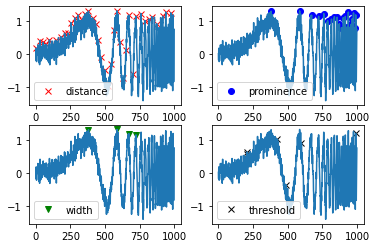

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

x = np.sin(2*np.pi*(2**np.linspace(2,10,1000))*np.arange(1000)/48000) + np.random.normal(0, 1, 1000) * 0.15
print(x)
print(x.shape)
peaks, _ = find_peaks(x, distance=20)
print(peaks)
print(peaks.shape)
peaks2, _ = find_peaks(x, prominence=1)      # BEST!
peaks3, _ = find_peaks(x, width=20)
peaks4, _ = find_peaks(x, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless
plt.subplot(2, 2, 1)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x[peaks3], "vg"); plt.plot(x); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x[peaks4], "xk"); plt.plot(x); plt.legend(['threshold'])
plt.show()

In [20]:
    from scipy.signal import find_peaks
    import numpy as np
 

    def segment(x, y):
        ind_peaks, properties = find_peaks(y)
        y_peaks = y[ind_peaks]
        peaks = x[y_peaks]
        seg_vec = np.zeros((np.size(peaks)))            
        for k in range(0, np.size(peaks) -1):
            zakm = np.argwhere((x <= peaks[k+1]) & (x >= peaks[k]))
            warty = y[zakm]
            miny = min(warty)
            idxm_min_y = warty.index(miny)
            prawzak = zakm(idxm_min_y[1])
            seg_vec[k] = prawzak
        return seg_vec

    x = np.array([2000, 2000.80008, 2001.60016, 2002.40024, 2003.20032, 2004.0004, 2004.80048, 2005.60056, 2006.40064, 2007.20072, 2008.0008, 2008.80088, 2009.60096, 2010.40104, 2011.20112, 2012.0012, 2012.80128, 2013.60136, 2014.40144])

    y = np.array([5.176121667, 5.356537992, 5.607329095, 5.854998494, 6.092435554, 6.319422405, 6.53596013, 6.757846164, 7.133741021, 7.474574592, 7.649857687, 7.635866015, 7.524608265, 7.294197667, 7.047367482, 6.687396005, 6.319912014, 5.928213139, 5.627291077])
    g = segment(x,y)

IndexError: arrays used as indices must be of integer (or boolean) type